# Machine Learning LAB 2: Perceptrons

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **PERCEPTRON**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [11]:
import numpy as np
import random as rnd
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [12]:
# Compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test =  X.shape[0] - m_training
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix
# The transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 479
Number of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [13]:
def to_homogeneous(X_training, X_test):
    # TODO: Transform the input into homogeneous coordinates
    n_train = X_training.shape[0]
    n_test = X_test.shape[0]
    Xh_training = np.hstack((np.ones((n_train, 1)), X_training))
    Xh_test = np.hstack((np.ones((n_test, 1)), X_test))
    return Xh_training, Xh_test

In [14]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## Deterministic perceptron

Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout.

The current version of the perceptron is **deterministic**: we use a fixed rule to decide which sample should be considered (e.g., the one with the lowest index).

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [15]:
def count_errors(current_w, X, Y):
    # This function:
    # -computes the number of misclassified samples
    # -returns the indexes of all misclassified samples
    # -if there are no misclassified samples, returns -1 as index
    # TODO: write the function
    Y_predicted  = np.sign(np.matmul(X, current_w))
    index = np.where(Y_predicted * Y <= 0)[0]
    n = len(index)
    if n == 0:
        return 0, -1
    return n, index

    
def perceptron_fixed_update(current_w, X, Y):
    # TODO: write the perceptron update function
    new_w = current_w
    n, index = count_errors(current_w, X, Y)
    if n > 0:
        idx = index[0]
        new_w += X[idx]*Y[idx]
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    # TODO: write the perceptron main loop
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    n_samples, n_features = X.shape[0], X.shape[1]
    current_w = np.zeros(n_features)
    best_error = 10e9
    n_iter = 0
    while (n_iter < max_num_iterations and best_error > 0):
        n_iter += 1
        current_w = perceptron_fixed_update(current_w, X, Y)
        print(f"Iteration {n_iter}: {current_w}")
        n, _ = count_errors(current_w, X, Y)
        error = n / n_samples
        print(f"Iteration {n_iter}: {error} {best_error}")
        if error < best_error:
            best_w = current_w.copy()
            best_error = error
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [16]:
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))
w_found2, error2 = perceptron_no_randomization(X_training,Y_training, 100)
print("Training Error of perceptron (100 iterations): " + str(error2))


print(f"Wfound: {w_found}")
print(f"Wfound 2: {w_found2}")

Iteration 1: [-1.          0.3798618   1.57020044 -0.85174963]
Iteration 1: 0.5133120340788072 10000000000.0
Iteration 2: [ 0.         -0.49939129  2.04200336  0.23492803]
Iteration 2: 0.36563720269790556 0.5133120340788072
Iteration 3: [ 1.         -1.25379655  1.42894016 -0.02923048]
Iteration 3: 0.3106141285055023 0.36563720269790556
Iteration 4: [ 0.         -3.03796367  0.0298587  -0.11746402]
Iteration 4: 0.3045793397231097 0.3106141285055023
Iteration 5: [-1.         -2.65810187  1.60005914 -0.96921364]
Iteration 5: 0.291089811856585 0.3045793397231097
Iteration 6: [ 0.         -3.45412307  0.50096264 -1.29210417]
Iteration 6: 0.31132410365637203 0.291089811856585
Iteration 7: [-1.         -3.65688444  0.90003849 -0.32316156]
Iteration 7: 0.27831025914093005 0.291089811856585
Iteration 8: [ 0.         -3.37089119  0.84599652 -1.64449621]
Iteration 8: 0.31913383031593895 0.27831025914093005
Iteration 9: [-1.         -3.57365256  1.24507237 -0.67555361]
Iteration 9: 0.275115370962

Now use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [17]:
def loss_estimate(w,X,Y):
    # Estimate the test loss
    n, _ = count_errors(w, X, Y)
    t_loss_estimate = n / X.shape[0]
    return t_loss_estimate


true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 
    
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

print(f"Wfound: {w_found}")
print(f"Wfound 2: {w_found2}")

Test Error of perceptron (30 iterations): 0.26382978723404255
Test Error of perceptron (100 iterations): 0.26382978723404255
Wfound: [-1.         -3.57365256  1.24507237 -0.67555361]
Wfound 2: [-1.         -3.57365256  1.24507237 -0.67555361]


### Randomized perceptron

Implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample. The functions will be very similar, except for some minor details.

In [18]:
def perceptron_randomized_update(current_w, X, Y):
    # TODO: write the perceptron update function
    new_w = current_w
    n, index = count_errors(current_w, X, Y)
    if n > 0:
        idx = np.random.choice(index, size = 1)[0]
        new_w += X[idx]*Y[idx]
    return new_w

def perceptron_with_randomization(X, Y, max_num_iterations):
    # TODO: write the perceptron main loop
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    n_samples, n_features = X.shape[0], X.shape[1]
    current_w = np.zeros(n_features)
    best_error = 10e9
    n_iter = 0
    while (n_iter < max_num_iterations and best_error > 0):
        n_iter += 1
        current_w = perceptron_randomized_update(current_w, X, Y)
        n, _ = count_errors(current_w, X, Y)
        error = n / n_samples
        if error < best_error:
            best_w = current_w.copy()
            best_error = error
    return best_w, best_error

Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [19]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron_with_randomization(X_training, Y_training, 30)
w_found2, error2 = perceptron_with_randomization(X_training, Y_training, 100)
print("Training Error of perceptron (30 iterations): " + str(error))
print("Training Error of perceptron (100 iterations): " + str(error2))

true_loss_estimate =  loss_estimate(w_found, X_test, Y_test)       # Error rate on the test set
true_loss_estimate2 =  loss_estimate(w_found2, X_test, Y_test) 

print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate2))

Training Error of perceptron (30 iterations): 0.25097621583244584
Training Error of perceptron (100 iterations): 0.24565140220092296
Test Error of perceptron (30 iterations): 0.251063829787234
Test Error of perceptron (100 iterations): 0.2478723404255319


Iteration 1: [-1.          0.3798618   1.57020044 -0.85174963]
Iteration 1: 0.5133120340788072 10000000000.0
Iteration 2: [ 0.         -0.49939129  2.04200336  0.23492803]
Iteration 2: 0.36563720269790556 0.5133120340788072
Iteration 3: [ 1.         -1.25379655  1.42894016 -0.02923048]
Iteration 3: 0.3106141285055023 0.36563720269790556
Iteration 4: [ 0.         -3.03796367  0.0298587  -0.11746402]
Iteration 4: 0.3045793397231097 0.3106141285055023
Iteration 5: [-1.         -2.65810187  1.60005914 -0.96921364]
Iteration 5: 0.291089811856585 0.3045793397231097
Iteration 6: [ 0.         -3.45412307  0.50096264 -1.29210417]
Iteration 6: 0.31132410365637203 0.291089811856585
Iteration 7: [-1.         -3.65688444  0.90003849 -0.32316156]
Iteration 7: 0.27831025914093005 0.291089811856585
Iteration 8: [ 0.         -3.37089119  0.84599652 -1.64449621]
Iteration 8: 0.31913383031593895 0.27831025914093005
Iteration 9: [-1.         -3.57365256  1.24507237 -0.67555361]
Iteration 9: 0.275115370962

(0.0, 0.5)

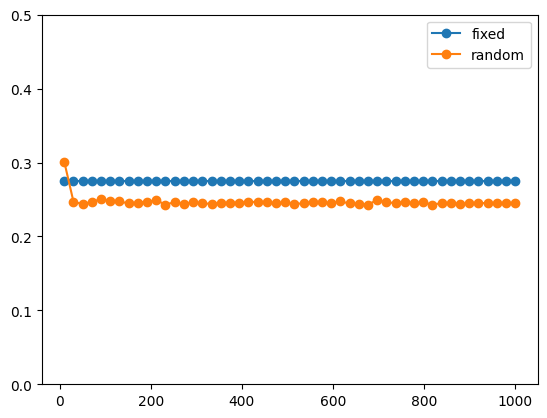

In [20]:
# TODO Plot the loss with respect to the number of iterations (up to 1000)

n_iter_vec = np.linspace(10, 1000, 50)
fixed_loss = []
randomized_loss = []

for max_num_iterations in n_iter_vec:
    w_fixed, _ = perceptron_no_randomization(X_training, Y_training, max_num_iterations)
    w_random, _ = perceptron_with_randomization(X_training, Y_training, max_num_iterations)
    fixed_loss.append(loss_estimate(w_fixed, X_training, Y_training))
    randomized_loss.append(loss_estimate(w_random, X_training, Y_training))


plt.plot(n_iter_vec, fixed_loss, marker = "o", label = "fixed")
plt.plot(n_iter_vec, randomized_loss,  marker = "o", label = "random")
plt.legend()
plt.ylim(0, 0.5)

# Be EXTREMELY CAREFUL when copying arrays

In [9]:
import numpy as np
w = np.array([1,2,3,4,5])


# IN-PLACE OPERATIONS ALSO CHANGE THE OTHER OBJECT
best_w = w
w[0] = 10
print(w, best_w)

w = np.array([1,2,3,4,5])
best_w = w
w += np.array([1,1,1,1,1]) # THIS ALSO COUNTS AS AN IN-PLACE OPERATION
print(w, best_w)


# OPERATIONS THAT RE-ASSIGN THE ARRAY DO NOT CHANGE THE OTHER OBJECT
w = np.array([1,2,3,4,5])
best_w = w
w = w + np.array([1,1,1,1,1])
print(w, best_w)


# TO AVOID MISTAKES, ALWAYS COPY EXPLICITLY WITH .COPY()

[10  2  3  4  5] [10  2  3  4  5]
[2 3 4 5 6] [2 3 4 5 6]
[2 3 4 5 6] [1 2 3 4 5]
